In [4]:
!pip install tensorflow --quiet

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
from glob import glob

In [43]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.data import AUTOTUNE
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import tensorflow as tf

In [15]:
#uncomment when NOT using colab:
directory = "../../raw_data/dataset-resized/"

#uncomment below when using colab:
#from google.colab import drive
#drive.mount('/content/drive')
#directory = "/content/dataset-original"

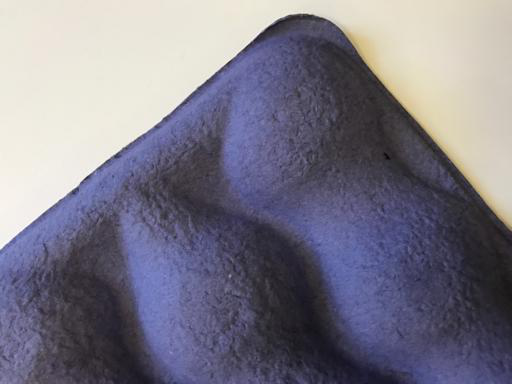

In [17]:
paper = list(glob(f'{directory}/paper/*'))
# print(paper)
PIL.Image.open(str(paper[0]))

In [18]:
batch_size = 32
img_height = 180
img_width = 180

In [19]:
train_ds = image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


2021-08-30 16:15:43.433204: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
val_ds = image_dataset_from_directory(
  directory,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [21]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


2021-08-30 16:15:56.697052: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


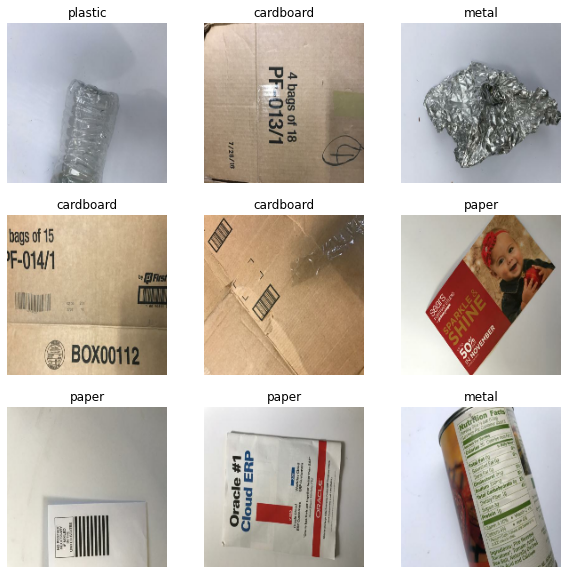

In [22]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [24]:
AUTOTUNE = AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [62]:
def create_main_layer(model_type):
    input_shape=(180, 180, 3)
    if model_type == "ResNet50":
        from tensorflow.keras.applications import ResNet50
        base_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")
        for layer in base_model.layers:
            layer.trainable = False
    elif model_type == "simple":
        normalization_layer = Rescaling(1./255, input_shape=input_shape)
        base_model = Sequential([
                        normalization_layer,
                        Conv2D(32, 3, activation='relu'),
                        MaxPooling2D(),
                        Conv2D(32, 3, activation='relu'),
                        MaxPooling2D(),
                        Conv2D(32, 3, activation='relu'),
                        MaxPooling2D()])
    else:
        raise Exception(f"model {model_type} not supported")
    x = tf.keras.layers.Flatten()(base_model.output)
    model = tf.keras.models.Model(base_model.input, x)
    return model

In [67]:
def train_model(model_type, epochs):
    num_classes = 6

    model = Sequential([
      create_main_layer(model_type),
      Dense(128, activation='relu'),
      Dense(num_classes)
    ])
    model.compile(
      optimizer='adam',
      loss=SparseCategoricalCrossentropy(from_logits=True),
      metrics=['accuracy'])
    model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )
    return model

In [68]:
simple_model = train_model("simple", 5)

Epoch 1/5
64/64 [==============================] - 38s 580ms/step - loss: 1.5884 - accuracy: 0.3314 - val_loss: 1.4087 - val_accuracy: 0.4475
Epoch 2/5
64/64 [==============================] - 43s 671ms/step - loss: 1.3170 - accuracy: 0.4738 - val_loss: 1.2807 - val_accuracy: 0.5050
Epoch 3/5
64/64 [==============================] - 50s 782ms/step - loss: 1.1714 - accuracy: 0.5302 - val_loss: 1.1421 - val_accuracy: 0.5584
Epoch 4/5
64/64 [==============================] - 37s 579ms/step - loss: 1.0224 - accuracy: 0.6123 - val_loss: 1.1072 - val_accuracy: 0.6218
Epoch 5/5
64/64 [==============================] - 35s 543ms/step - loss: 0.8998 - accuracy: 0.6642 - val_loss: 1.1540 - val_accuracy: 0.5842


In [69]:
resnet50_model = train_model("ResNet50", 5)

Epoch 1/5
64/64 [==============================] - 136s 2s/step - loss: 4.0152 - accuracy: 0.6113 - val_loss: 0.8109 - val_accuracy: 0.7287
Epoch 2/5
64/64 [==============================] - 137s 2s/step - loss: 0.3409 - accuracy: 0.8882 - val_loss: 0.6471 - val_accuracy: 0.8020
Epoch 3/5
64/64 [==============================] - 145s 2s/step - loss: 0.1239 - accuracy: 0.9599 - val_loss: 0.6558 - val_accuracy: 0.8238
Epoch 4/5
64/64 [==============================] - 145s 2s/step - loss: 0.0864 - accuracy: 0.9708 - val_loss: 0.7702 - val_accuracy: 0.7901
Epoch 5/5
64/64 [==============================] - 150s 2s/step - loss: 0.0637 - accuracy: 0.9787 - val_loss: 0.8509 - val_accuracy: 0.8238
